In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import joblib
import pathlib as path
import copy
import modularNN as mnn

In [2]:
### Static
rawData = pd.read_csv('STEMVisualsSynthData.csv', header=0)
#remove unneeded column
rawData.drop('Index_within_Experiment', axis = 1, inplace = True)
#X is inputs--the three Concentrations, F_in, I0 (light intensity), and c_N_in (6)
X = rawData[['Time', 'C_X', 'C_N', 'C_L', 'F_in', 'C_N_in', 'I0']]
Y = X.copy(deep=True)
#drop unnecessary rows in Y
Y.drop('F_in', axis = 1, inplace = True)
Y.drop('C_N_in', axis = 1, inplace = True)
Y.drop('I0', axis = 1, inplace = True)
Y.drop('Time', axis = 1, inplace = True)
#Y vals should be X concentrations one timestep ahead, so remove the first index
Y.drop(index=0, inplace=True)
#To keep the two consistent, remove the last index of X
X.drop(index=19999, inplace=True)

#user defined parameters: current values can serve as a default
#splits - expects 3 floats that add to 1
trainSplit = 0.6
valSplit = 0.2
testSplit = 0.2
#model params
initNeuronNum = 18 #number of neurons in the first layer, 7 < int < 100
loss = 1 #0 = MSE, 1 = MAE
optimizer = 0 #0 = Adam, 1 = SGD
learnRate = 0.001 #0.0001 < float < 0.01
#training params
epochs = 100 #0 < int < 200
batchSize = 25 #0 < int < 200

#set device
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

C:\Users\kenda\AppData\Local\Temp\ipykernel_54844\3538755646.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index=19999, inplace=True)


In [3]:
#test the all-in-one function
model, Y_test_tensor, testPreds, XTestTime = mnn.trainAndSaveModel(X, Y, trainSplit, valSplit, testSplit, initNeuronNum, loss, optimizer, learnRate, epochs, batchSize, device)
#read in the loss CSV
lossCSV = pd.read_csv('models/losses.csv', header=0)
#TODO:plot the losses against epochs (stored as indexes)

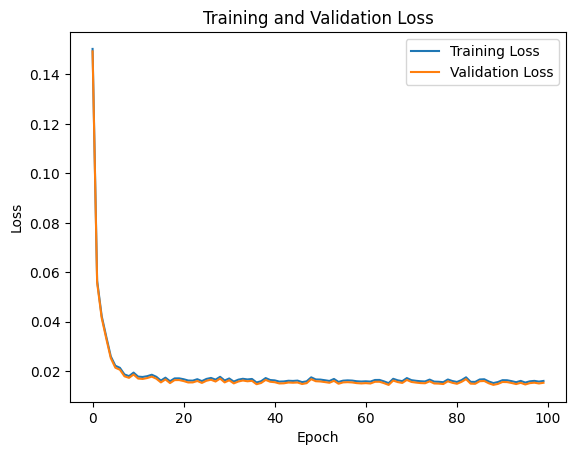

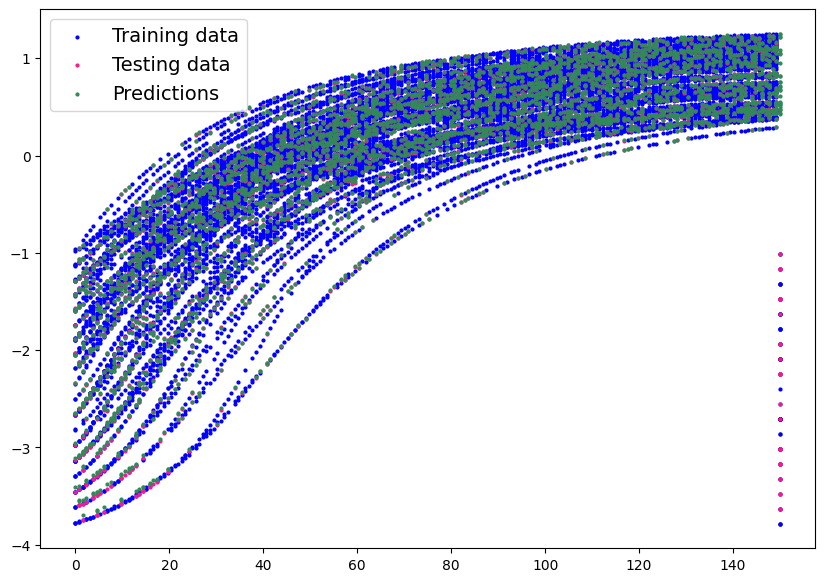

In [5]:
#split the data
X_train, X_val, X_test, Y_train, Y_val, Y_test, XTrainTime, XValTime, XTestTime = mnn.dataSplitter(X, Y, trainSplit, valSplit, testSplit)
#scale the data
stScalerX, stScalerY, X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled= mnn.scaleData(X_train, X_val, X_test, Y_train, Y_val, Y_test)
#tensorize the data
X_train_tensor, X_val_tensor, X_test_tensor, Y_train_tensor, Y_val_tensor, Y_test_tensor = mnn.tensors(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled)
#if possible, move the tensors to the GPU
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
Y_val_tensor = Y_val_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

#create the model
model, lossFunction, optimizer = mnn.modelCreator(initNeuronNum, loss, optimizer, learnRate)
#if possible, move the model to the GPU
model = model.to(device)
#train the model
model, trainLoss, valLoss = mnn.trainModel(model, lossFunction, optimizer, epochs, batchSize, X_train_tensor, X_val_tensor, Y_train_tensor, Y_val_tensor)
#test the model
#testLoss = mnn.testModel(model, lossFunction, X_test_tensor, Y_test_tensor)
#plot the results
mnn.plotter(trainLoss, valLoss)
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  y_preds = model(X_test_tensor)
mnn.plot_predictions(train_data=XTrainTime, 
                     train_labels=Y_train_tensor[:, 0], 
                     test_data=XTestTime, 
                     test_labels=Y_test_tensor[:, 0], 
                     predictions= torch.Tensor.cpu(y_preds[:, 0]))
#save the model
mnn.saveModel(model, stScalerX, stScalerY)

In [4]:
mnn.plot_predictions(train_data=XTrainTime,
                        train_labels=Y_train_tensor[:, 2],
                        test_data=XTestTime,
                        test_labels=Y_test_tensor[:, 2],
                        predictions=y_preds[:, 2])

NameError: name 'XTrainTime' is not defined

In [ ]:
#for loop to find best model
#create array to hold best model parameters
bestModel = []
#hold best loss
bestLoss = np.inf #start at infinity
#neuronnum, loss, opt are static
initNeuronNum = 18
loss = 1
opt = 0
#learnRate will be between 0.0001 and 0.01, step size 0.001
for lr in range(1, 100, 10):
        learnRate = lr/10000
        #print learn rate
        print("Learning Rate: ", learnRate)
        #epochs will be between 25 and 200, step size 25
        for epoch in range(50, 150, 25):
            epochs = epoch
            #print epoch
            print("Epochs: ", epochs)
            #batchSize will be between 25 and 200, step size 25
            for batch in range(25, 200, 25):
                batchSize = batch
                #print batch size
                print("Batch Size: ", batchSize)
                #splits will be .6 train, .2 val, .2 test
                trainSplit = 0.6
                valSplit = 0.2
                testSplit = 0.2
                #split the data
                X_train, X_val, X_test, Y_train, Y_val, Y_test, XTrainTime, XValTime, XTestTime = mnn.dataSplitter(X, Y, trainSplit, valSplit, testSplit)
                #scale the data
                stScalerX, stScalerY, X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled= mnn.scaleData(X_train, X_val, X_test, Y_train, Y_val, Y_test)
                #tensorize the data
                X_train_tensor, X_val_tensor, X_test_tensor, Y_train_tensor, Y_val_tensor, Y_test_tensor = mnn.tensors(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled)
                #if possible, move the tensors to the GPU
                X_train_tensor = X_train_tensor.to(device)
                X_val_tensor = X_val_tensor.to(device)
                X_test_tensor = X_test_tensor.to(device)
                Y_train_tensor = Y_train_tensor.to(device)
                Y_val_tensor = Y_val_tensor.to(device)
                Y_test_tensor = Y_test_tensor.to(device)

                #create the model
                model, lossFunction, optimizer = mnn.modelCreator(initNeuronNum, loss, optimizer, learnRate)
                #if possible, move the model to the GPU
                model = model.to(device)
                #train the model
                model, trainLoss, valLoss = mnn.trainModel(model, lossFunction, optimizer, epochs, batchSize, X_train_tensor, X_val_tensor, Y_train_tensor, Y_val_tensor)
                #if the model is better than the current best model, save it
                if valLoss[epochs-1] < bestLoss: #if the last value in the validation loss is less than the current best loss
                    bestLoss = valLoss[epochs-1] #set the best loss to the last value in the validation loss
                    bestModel = [initNeuronNum, loss, optimizer, learnRate, epochs, batchSize] #set the best model parameters to the current model parameters
                        


Learning Rate:  0.0001
Epochs:  50
Batch Size:  25
Batch Size:  50
Batch Size:  75
Batch Size:  100
Batch Size:  125
Batch Size:  150
Batch Size:  175
Epochs:  75
Batch Size:  25
Batch Size:  50
Batch Size:  75
Batch Size:  100
Batch Size:  125
Batch Size:  150
Batch Size:  175
Epochs:  100
Batch Size:  25
Batch Size:  50
Batch Size:  75
Batch Size:  100
Batch Size:  125
Batch Size:  150
Batch Size:  175
Epochs:  125
Batch Size:  25
Batch Size:  50
Batch Size:  75
Batch Size:  100
Batch Size:  125
Batch Size:  150
Batch Size:  175
Learning Rate:  0.0011
Epochs:  50
Batch Size:  25
Batch Size:  50
Batch Size:  75
Batch Size:  100
Batch Size:  125
Batch Size:  150
Batch Size:  175
Epochs:  75
Batch Size:  25
Batch Size:  50
Batch Size:  75
Batch Size:  100
Batch Size:  125
Batch Size:  150
Batch Size:  175
Epochs:  100
Batch Size:  25
Batch Size:  50
Batch Size:  75
Batch Size:  100
Batch Size:  125
Batch Size:  150
Batch Size:  175
Epochs:  125
Batch Size:  25
Batch Size:  50
Batch Size

In [ ]:
print(bestModel)

[18, 1, Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
), 0.0081, 100, 25]
